<a href="https://colab.research.google.com/github/TonyQ2k3/pytorch-training/blob/main/notebooks/pytorch_day7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch Day 7 - Computer Vision with Pytorch
---

## Convolutional Neural Network

A type of deep learning model commonly used for analysing visual data.

Key components:
+ Apply convolutional operations to detect edges and shapes.
+ Hidden layer activation function: ReLU

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

In [12]:
# Download helper function
import requests
from pathlib import Path

if Path("helper_functions.py").is_file() is not True:
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

## Getting a dataset

### 1. `torchvision.datasets`

In [2]:
fashion_dataset = datasets.FashionMNIST(
  root='dataset/',
  download=True,
  train=True,
  transform=ToTensor(),
  target_transform=None
)


100%|██████████| 26421880/26421880 [00:02<00:00, 12061346.11it/s]


Extracting dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 204707.95it/s]


Extracting dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:04<00:00, 987023.02it/s] 


Extracting dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6621366.76it/s]

Extracting dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



In [3]:
fashion_datatest = datasets.FashionMNIST(
    root='dataset',
    download=True,
    train=False,
    transform=ToTensor(),
    target_transform=None
)

In [4]:
# Checking the classes
class_names = fashion_dataset.classes
print(class_names)
print(fashion_dataset.class_to_idx)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


In [5]:
# Checking the shape
images = fashion_dataset.data
targets = fashion_dataset.targets
print(images.shape)
print(targets.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


In [6]:
# Image size
print(images[0].shape)

torch.Size([28, 28])


### 2. Image visualization

In [7]:
# Extract images and labels
images = fashion_dataset.data
labels = fashion_dataset.targets

Text(0.5, 1.0, 'Sneaker')

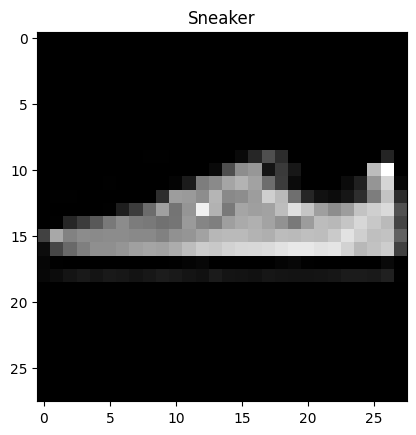

In [8]:
# Visualize using plt.imshow()
index = torch.randint(0, 60000, dtype=torch.int, size=[1]).item()
plt.imshow(X=images[index], cmap='gray')
plt.title(class_names[labels[index]])

## Data preparation

### 1. DataLoader

As of now, our data is a Pytorch dataset.
A dataloader transform it into a Python iterable.
We need to turn our data into batches (aka mini-batches)

### 2. Mini-batches

Reason for batches:
+ Splitting up large dataset makes it more efficient to process
+ batch size = how much data get processed at a time
+ Gives model more time to update gradient per epoch

In [9]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset=fashion_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=fashion_datatest,
    batch_size=BATCH_SIZE,
    shuffle=True
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7bf971263c70>,
 <torch.utils.data.dataloader.DataLoader at 0x7bf971263a30>)

## Building a Baseline Model

In [10]:
class FashionMnistModelv0(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_shape, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, output_shape)
    )

  def forward(self, x):
    return self.layer_stack(x)

In [11]:
torch.manual_seed(42)
model = FashionMnistModelv0(
  input_shape=28*28,
  hidden_units=10,
  output_shape=len(class_names)
)
model

FashionMnistModelv0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
    (5): Linear(in_features=10, out_features=10, bias=True)
  )
)

## Training Process

### Loss functions and Optimizer

Multi-class classification:
+ Loss function: `nn.CrossEntropyLoss()`
+ Optimizer: `torch.optim.SGD()` or `torch.optim.Adam()`
+ Evaluation: Accuracy

In [13]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [14]:
training_losses = []
testing_losses = []

### Training Loop

In [16]:
# Setup progress bar
from tqdm.auto import tqdm


# Number of epochs
epochs = 100
eps = [x for x in range(1, epochs+1)]

for epoch in tqdm(range(epochs)):
  # Looping through every batch, within every epoch
  for batch, (image, label) in enumerate(train_dataloader):
    # Train
    model.train()

    y_logits = model(image)
    loss = loss_fn(y_logits, label)
    training_losses.append(loss)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  # Eval
  model.eval()
  with torch.inference_mode():
    for test_image, test_label in test_dataloader:
      y_test = model(test_image)
      test_loss = loss_fn(y_test, test_label)
      testing_losses.append(test_loss)

  if epoch % 10 == 0:
    print(f"Epoch {epoch}: Train loss = {loss} | Test loss = {test_loss}")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0: Train loss = 0.7044632434844971 | Test loss = 0.5753015875816345
Epoch 10: Train loss = 0.25855356454849243 | Test loss = 0.33598557114601135
Epoch 20: Train loss = 0.3175349235534668 | Test loss = 0.18295998871326447
Epoch 30: Train loss = 0.29776519536972046 | Test loss = 0.6631083488464355
Epoch 40: Train loss = 0.5241410136222839 | Test loss = 0.3293799161911011
Epoch 50: Train loss = 0.24328404664993286 | Test loss = 0.4935345947742462
Epoch 60: Train loss = 0.5714736580848694 | Test loss = 0.5490293502807617
Epoch 70: Train loss = 0.2897193431854248 | Test loss = 0.08046209067106247
Epoch 80: Train loss = 0.1778423935174942 | Test loss = 0.3479074537754059
Epoch 90: Train loss = 0.3587917387485504 | Test loss = 0.1870511770248413
